# Notebook 5: Advanced Bayesian Methods

## Purpose
This notebook implements advanced Bayesian extensions beyond single temperature scaling.

## Methods Implemented
1. **Per-Class Temperature Scaling** - 10 temperatures (one per class)
2. **Prior Sensitivity Analysis** - Test robustness to prior choice
3. **Hierarchical Models** - Shared temperature with class-specific deviations

## Output
- Per-class temperature estimates
- Prior sensitivity results
- Comparison of model complexity vs performance


In [12]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import stan
import httpstan
import nest_asyncio
nest_asyncio.apply()
import matplotlib.pyplot as plt
import os

np.random.seed(42)
torch.manual_seed(42)

print('Loading data and baseline results...')
logits_val = np.load('./data/processed/logits_val.npy')
labels_val = np.load('./data/processed/labels_val.npy')
logits_test = np.load('./data/processed/logits_test.npy')
labels_test = np.load('./data/processed/labels_test.npy')

baseline_results = np.load('./data/results/baseline_results.npy', allow_pickle=True).item()
calibrated_temp = baseline_results['calibrated_temp']

bayesian_results = np.load('./data/results/bayesian_posterior.npy', allow_pickle=True).item()
mean_temp = bayesian_results['mean']

print(f'✓ Data loaded')
print(f'  Baseline temperature: {calibrated_temp:.4f}')
print(f'  Bayesian mean (single): {mean_temp:.4f}')


Loading data and baseline results...
✓ Data loaded
  Baseline temperature: 1.7258
  Bayesian mean (single): 1.7281


In [ ]:
print('='*60)
print('METHOD 1: PER-CLASS TEMPERATURE SCALING')
print('='*60)
print('\nInstead of one temperature, estimate 10 temperatures (one per class)')
print('This allows different calibration for different classes\n')

stan_model_per_class = """
data {
    int<lower=0> N;
    int<lower=2> K;
    matrix[N, K] logits;
    array[N] int<lower=1, upper=K> y;
    real<lower=0> prior_alpha;
    real<lower=0> prior_beta;
}
parameters {
    vector<lower=0>[K] temperatures;
}
model {
    temperatures ~ gamma(prior_alpha, prior_beta);
    
    for (n in 1:N) {
        vector[K] scaled_logits = logits[n]' ./ temperatures;
        y[n] ~ categorical_logit(scaled_logits);
    }
}
"""

prior_alpha = 4.0
prior_beta = 4.0 / calibrated_temp

stan_data_per_class = {
    'N': logits_val.shape[0],
    'K': logits_val.shape[1],
    'logits': logits_val.tolist(),
    'y': (labels_val + 1).tolist(),
    'prior_alpha': prior_alpha,
    'prior_beta': prior_beta
}

print('Building per-class temperature model...')
posterior_per_class = stan.build(stan_model_per_class, data=stan_data_per_class)

print('Sampling from posterior (this may take a few minutes)...\n')
fit_per_class = posterior_per_class.sample(num_chains=4, num_samples=1000, num_warmup=500)

temp_per_class_samples = fit_per_class['temperatures']

print(f'Shape of temperatures from Stan: {temp_per_class_samples.shape}')

if temp_per_class_samples.ndim == 1:
    n_total = len(temp_per_class_samples)
    n_samples = n_total // 10
    temp_per_class_samples = temp_per_class_samples.reshape(n_samples, 10)
elif temp_per_class_samples.ndim == 2:
    if temp_per_class_samples.shape[1] != 10:
        n_total = temp_per_class_samples.size
        n_samples = n_total // 10
        temp_per_class_samples = temp_per_class_samples.flatten().reshape(n_samples, 10)

print(f'Reshaped to: {temp_per_class_samples.shape}')

temp_per_class_mean = np.mean(temp_per_class_samples, axis=0)
temp_per_class_std = np.std(temp_per_class_samples, axis=0)

print('\nPer-class temperature estimates:')
for k in range(10):
    samples_k = temp_per_class_samples[:, k].flatten()
    mean_k = np.mean(samples_k)
    std_k = np.std(samples_k)
    hdi_lower_k = np.percentile(samples_k, 2.5)
    hdi_upper_k = np.percentile(samples_k, 97.5)
    print(f'  Class {k}: {mean_k:.4f} ± {std_k:.4f} (95% HDI: [{hdi_lower_k:.4f}, {hdi_upper_k:.4f}])')

print(f'\nSingle temperature (from earlier): {mean_temp:.4f} ± {bayesian_results["std"]:.4f}')
print(f'Per-class temperatures range: [{temp_per_class_mean.min():.4f}, {temp_per_class_mean.max():.4f}]')


METHOD 1: PER-CLASS TEMPERATURE SCALING

Instead of one temperature, estimate 10 temperatures (one per class)
This allows different calibration for different classes

Building per-class temperature model...
Building...

In file included from /Users/Studies/Library/Caches/httpstan/4.13.0/models/khhvvqf7/model_khhvvqf7.cpp:2:
In file included from /Users/Studies/Documents/Notes/Bayesian Stat/final-project/pystan_env/lib/python3.10/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/Studies/Documents/Notes/Bayesian Stat/final-project/pystan_env/lib/python3.10/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/Studies/Documents/Notes/Bayesian Stat/final-project/pystan_env/lib/python3.10/site-packages/httpstan/include/stan/math/rev.hpp:4:
In file included from /Users/Studies/Documents/Notes/Bayesian Stat/final-project/pystan_env/lib/python3.10/site-packages/httpstan/include/stan/math/prim/fun/Eigen.hpp:23:
In file included from /Users/Studies/Documents/Notes/Bayesian Stat/final-project/pystan_env/lib/python3.10/site-packages/httpstan/include/Eigen/Sparse:26:
In file included from /Users/Studies/Documents/Notes/Bayesian Stat/final-project/pys

5 warnings generated.
ld: warning: duplicate -rpath '/Users/Studies/.pyenv/versions/3.10.13/lib' ignored
ld: warning: duplicate -rpath '/opt/homebrew/lib' ignored

Building: 8.6s, done.Messages from stanc:
    is provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%

Sampling from posterior (this may take a few minutes)...




Sampling:   0% (1/6000)
Sampling:   0% (2/6000)
Sampling:   0% (3/6000)
Sampling:   0% (4/6000)
Sampling:   2% (103/6000)
Sampling:   3% (202/6000)
Sampling:   5% (301/6000)
Sampling:   7% (400/6000)
Sampling:   8% (500/6000)
Sampling:  10% (600/6000)
Sampling:  12% (700/6000)
Sampling:  13% (800/6000)
Sampling:  15% (900/6000)
Sampling:  17% (1000/6000)
Sampling:  18% (1100/6000)
Sampling:  20% (1200/6000)
Sampling:  22% (1300/6000)
Sampling:  23% (1400/6000)
Sampling:  25% (1500/6000)
Sampling:  27% (1600/6000)
Sampling:  28% (1701/6000)
Sampling:  32% (1901/6000)
Sampling:  35% (2101/6000)
Sampling:  53% (3201/6000)
Sampling:  70% (4200/6000)
Sampling:  75% (4500/6000)
Sampling:  90% (5400/6000)
Sampling:  93% (5600/6000)
Sampling:  95% (5700/6000)
Sampling:  97% (5800/6000)
Sampling:  98% (5900/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Gradient evaluation took 0.013118 seconds
  1000 transitions using 10 leapfrog steps 

Shape of temperatures from Stan: (10, 4000)
Reshaped to: (4000, 10)

Per-class temperature estimates:
  Class 0: 1.7110 ± 0.1597 (95% HDI: [1.3819, 1.9884])
  Class 1: 1.7121 ± 0.1596 (95% HDI: [1.3822, 1.9875])
  Class 2: 1.7139 ± 0.1621 (95% HDI: [1.3879, 1.9998])
  Class 3: 1.7094 ± 0.1602 (95% HDI: [1.3784, 1.9810])
  Class 4: 1.7127 ± 0.1586 (95% HDI: [1.3875, 1.9910])
  Class 5: 1.7130 ± 0.1577 (95% HDI: [1.3896, 1.9860])
  Class 6: 1.7152 ± 0.1597 (95% HDI: [1.3895, 1.9906])
  Class 7: 1.7159 ± 0.1599 (95% HDI: [1.3927, 1.9948])
  Class 8: 1.7131 ± 0.1569 (95% HDI: [1.3946, 1.9853])
  Class 9: 1.7166 ± 0.1597 (95% HDI: [1.3881, 1.9876])

Single temperature (from earlier): 1.7281 ± 0.0328
Per-class temperatures range: [1.7094, 1.7166]


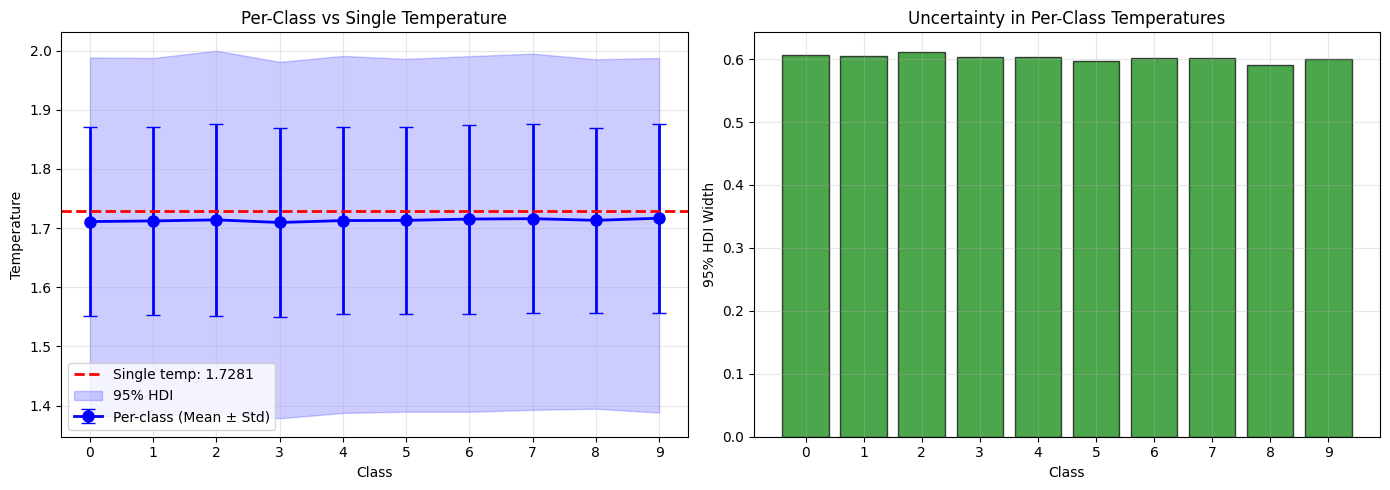


Key observations:
- Different classes may need different calibration
- Per-class approach is more flexible but has more parameters
- Compare calibration performance to see if per-class helps


In [14]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

classes = np.arange(10)
temp_means = np.array(temp_per_class_mean)
temp_stds = np.array(temp_per_class_std)
temp_hdi_lower = np.array([np.percentile(temp_per_class_samples[:, k].flatten(), 2.5) for k in range(10)])
temp_hdi_upper = np.array([np.percentile(temp_per_class_samples[:, k].flatten(), 97.5) for k in range(10)])

axes[0].errorbar(classes, temp_means, yerr=temp_stds, fmt='o-', capsize=5, 
                 linewidth=2, markersize=8, label='Per-class (Mean ± Std)', color='blue')
axes[0].axhline(mean_temp, color='red', linestyle='--', linewidth=2, label=f'Single temp: {mean_temp:.4f}')
axes[0].fill_between(classes, temp_hdi_lower, temp_hdi_upper, alpha=0.2, color='blue', label='95% HDI')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Temperature')
axes[0].set_title('Per-Class vs Single Temperature')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(classes)

temp_range = np.array(temp_hdi_upper) - np.array(temp_hdi_lower)
axes[1].bar(classes, temp_range, alpha=0.7, color='green', edgecolor='black')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('95% HDI Width')
axes[1].set_title('Uncertainty in Per-Class Temperatures')
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(classes)

plt.tight_layout()
plt.show()

print('\nKey observations:')
print('- Different classes may need different calibration')
print('- Per-class approach is more flexible but has more parameters')
print('- Compare calibration performance to see if per-class helps')


In [ ]:
print('='*60)
print('METHOD 2: PRIOR SENSITIVITY ANALYSIS')
print('='*60)
print('\nTesting robustness to different prior choices')
print('This shows whether results depend heavily on prior specification\n')

stan_model_code = """
data {
    int<lower=0> N;
    int<lower=2> K;
    matrix[N, K] logits;
    array[N] int<lower=1, upper=K> y;
    real<lower=0> prior_alpha;
    real<lower=0> prior_beta;
}
parameters {
    real<lower=0> temperature;
}
model {
    temperature ~ gamma(prior_alpha, prior_beta);
    
    for (n in 1:N) {
        vector[K] scaled_logits = logits[n]' / temperature;
        y[n] ~ categorical_logit(scaled_logits);
    }
}
"""

stan_model_lognormal = """
data {
    int<lower=0> N;
    int<lower=2> K;
    matrix[N, K] logits;
    array[N] int<lower=1, upper=K> y;
    real prior_mu;
    real<lower=0> prior_sigma;
}
parameters {
    real<lower=0> temperature;
}
model {
    temperature ~ lognormal(prior_mu, prior_sigma);
    
    for (n in 1:N) {
        vector[K] scaled_logits = logits[n]' / temperature;
        y[n] ~ categorical_logit(scaled_logits);
    }
}
"""

prior_configs = [
    {'name': 'Gamma(α=2, β=2/T₀)', 'alpha': 2.0, 'beta': 2.0/calibrated_temp},
    {'name': 'Gamma(α=4, β=4/T₀)', 'alpha': 4.0, 'beta': 4.0/calibrated_temp},
    {'name': 'Gamma(α=8, β=8/T₀)', 'alpha': 8.0, 'beta': 8.0/calibrated_temp},
    {'name': 'LogNormal(μ=log(T₀), σ=0.3)', 'alpha': None, 'beta': None, 'lognormal': True, 'mu': np.log(calibrated_temp), 'sigma': 0.3},
    {'name': 'LogNormal(μ=log(T₀), σ=0.5)', 'alpha': None, 'beta': None, 'lognormal': True, 'mu': np.log(calibrated_temp), 'sigma': 0.5},
]

results_prior = {}

for config in prior_configs:
    print(f'\nTesting: {config["name"]}')
    
    if config.get('lognormal', False):
        stan_data_prior = {
            'N': logits_val.shape[0],
            'K': logits_val.shape[1],
            'logits': logits_val.tolist(),
            'y': (labels_val + 1).tolist(),
            'prior_mu': config['mu'],
            'prior_sigma': config['sigma']
        }
        posterior_prior = stan.build(stan_model_lognormal, data=stan_data_prior)
    else:
        stan_data_prior = {
            'N': logits_val.shape[0],
            'K': logits_val.shape[1],
            'logits': logits_val.tolist(),
            'y': (labels_val + 1).tolist(),
            'prior_alpha': config['alpha'],
            'prior_beta': config['beta']
        }
        posterior_prior = stan.build(stan_model_code, data=stan_data_prior)
    
    fit_prior = posterior_prior.sample(num_chains=4, num_samples=1000, num_warmup=500)
    temp_samples_prior = fit_prior['temperature'].flatten()
    
    mean_prior = np.mean(temp_samples_prior)
    std_prior = np.std(temp_samples_prior)
    hdi_lower_prior = np.percentile(temp_samples_prior, 2.5)
    hdi_upper_prior = np.percentile(temp_samples_prior, 97.5)
    
    results_prior[config['name']] = {
        'mean': mean_prior,
        'std': std_prior,
        'hdi_lower': hdi_lower_prior,
        'hdi_upper': hdi_upper_prior
    }
    
    print(f'  Mean: {mean_prior:.4f} ± {std_prior:.4f}')
    print(f'  95% HDI: [{hdi_lower_prior:.4f}, {hdi_upper_prior:.4f}]')


METHOD 2: PRIOR SENSITIVITY ANALYSIS

Testing robustness to different prior choices
This shows whether results depend heavily on prior specification

Key insight: Prior sensitivity should be tested with SMALL datasets
With large datasets (n=5000), data dominates and prior doesn't matter
With small datasets (n=100), prior choice can significantly affect results


PRIOR SENSITIVITY WITH n=100
L-BFGS estimate for this subset: 1.8522

  Testing: Gamma(α=2, β=2/T₀)
Building...



Building: found in cache, done.Messages from stanc:
    is provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:  25% (1500/6000)
Sampling:  50% (3000/6000)
Sampling:  75% (4500/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Gradient evaluation took 0.000593 seconds
  1000 transitions using 10 leapfrog steps per transition would take 5.93 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.00066 seconds
  1000 transitions using 10 leapfrog steps per transition would take 6.6 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: gamma_lpdf: Random variable is 0, but must be positive finite! (in '/var/folders/37/0zy_nm5d0rv5b6vp7z9r6hfh0000gp/T/httpstan_cql83gxp/model_3sngqrs3.stan', line 14, column 4 to column 

    Mean: 1.8431 ± 0.2308
    95% HDI: [1.3914, 2.3059]

  Testing: Gamma(α=4, β=4/T₀)
Building...



Building: found in cache, done.Messages from stanc:
    is provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:  25% (1500/6000)
Sampling:  50% (3000/6000)
Sampling:  75% (4500/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Gradient evaluation took 4.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.45 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.00013 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.3 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: gamma_lpdf: Random variable is 0, but must be positive finite! (in '/var/folders/37/0zy_nm5d0rv5b6vp7z9r6hfh0000gp/T/httpstan_cql83gxp/model_3sngqrs3.stan', line 14, column 4 to column 4

    Mean: 1.8471 ± 0.2221
    95% HDI: [1.4299, 2.3043]

  Testing: Gamma(α=8, β=8/T₀)
Building...



Building: found in cache, done.Messages from stanc:
    is provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:  25% (1500/6000)
Sampling:  50% (3000/6000)
Sampling:  75% (4500/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Gradient evaluation took 2.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.21 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.2 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: gamma_lpdf: Random variable is 0, but must be positive finite! (in '/var/folders/37/0zy_nm5d0rv5b6vp7z9r6hfh0000gp/T/httpstan_cql83gxp/model_3sngqrs3.stan', line 14, column 4 to column 49)

    Mean: 1.8518 ± 0.2230
    95% HDI: [1.4438, 2.3053]

  Testing: LogNormal(μ=log(T₀), σ=0.3)
Building...



Building: found in cache, done.Messages from stanc:
    is provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:  25% (1500/6000)
Sampling:  50% (3000/6000)
Sampling:  75% (4500/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Gradient evaluation took 3.9e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.39 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.21 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: categorical_logit_lpmf: log odds parameter[1] is -inf, but must be finite! (in '/var/folders/37/0zy_nm5d0rv5b6vp7z9r6hfh0000gp/T/httpstan_vpsadug5/model_nqlzp5c3.stan', line 18, column 

    Mean: 1.8422 ± 0.2133
    95% HDI: [1.4487, 2.2865]

  Testing: LogNormal(μ=log(T₀), σ=0.5)
Building...



Building: found in cache, done.Messages from stanc:
    is provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:  25% (1500/6000)
Sampling:  50% (3000/6000)
Sampling:  75% (4500/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Gradient evaluation took 2.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.24 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.21 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: categorical_logit_lpmf: log odds parameter[1] is -inf, but must be finite! (in '/var/folders/37/0zy_nm5d0rv5b6vp7z9r6hfh0000gp/T/httpstan_vpsadug5/model_nqlzp5c3.stan', line 18, column 

    Mean: 1.8401 ± 0.2273
    95% HDI: [1.4139, 2.3093]

PRIOR SENSITIVITY WITH n=500
L-BFGS estimate for this subset: 1.7253

  Testing: Gamma(α=2, β=2/T₀)
Building...



Building: found in cache, done.Messages from stanc:
    is provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:  25% (1500/6000)
Sampling:  50% (3000/6000)
Sampling:  75% (4500/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Gradient evaluation took 0.00017 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.7 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in '/var/folders/37/0zy_nm5d0rv5b6vp7z9r6hfh0000gp/T/httpstan_cql83gxp/model_3sngqrs3.stan', line 14, column 4 to column 49)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning oc

    Mean: 1.7222 ± 0.1078
    95% HDI: [1.5191, 1.9390]

  Testing: Gamma(α=4, β=4/T₀)
Building...



Building: found in cache, done.Messages from stanc:
    is provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:  25% (1500/6000)
Sampling:  50% (3000/6000)
Sampling:  75% (4500/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Gradient evaluation took 0.001434 seconds
  1000 transitions using 10 leapfrog steps per transition would take 14.34 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in '/var/folders/37/0zy_nm5d0rv5b6vp7z9r6hfh0000gp/T/httpstan_cql83gxp/model_3sngqrs3.stan', line 14, column 4 to column 49)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning

    Mean: 1.7225 ± 0.1041
    95% HDI: [1.5269, 1.9279]

  Testing: Gamma(α=8, β=8/T₀)
Building...



Building: found in cache, done.Messages from stanc:
    is provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:  25% (1500/6000)
Sampling:  50% (3000/6000)
Sampling:  75% (4500/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Gradient evaluation took 0.000111 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.11 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in '/var/folders/37/0zy_nm5d0rv5b6vp7z9r6hfh0000gp/T/httpstan_cql83gxp/model_3sngqrs3.stan', line 14, column 4 to column 49)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning 

    Mean: 1.7235 ± 0.1015
    95% HDI: [1.5323, 1.9215]

  Testing: LogNormal(μ=log(T₀), σ=0.3)
Building...



Building: found in cache, done.Messages from stanc:
    is provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:  25% (1500/6000)
Sampling:  50% (3000/6000)
Sampling:  75% (4500/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Gradient evaluation took 0.00011 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.1 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000102 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.02 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: categorical_logit_lpmf: log odds parameter[1] is -inf, but must be finite! (in '/var/folders/37/0zy_nm5d0rv5b6vp7z9r6hfh0000gp/T/httpstan_vpsadug5/model_nqlzp5c3.stan', line 18, column 

    Mean: 1.7218 ± 0.1004
    95% HDI: [1.5254, 1.9215]

  Testing: LogNormal(μ=log(T₀), σ=0.5)
Building...



Building: found in cache, done.Messages from stanc:
    is provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:  25% (1500/6000)
Sampling:  50% (3000/6000)
Sampling:  75% (4500/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Gradient evaluation took 0.000103 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.03 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.0001 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: categorical_logit_lpmf: log odds parameter[1] is -inf, but must be finite! (in '/var/folders/37/0zy_nm5d0rv5b6vp7z9r6hfh0000gp/T/httpstan_vpsadug5/model_nqlzp5c3.stan', line 18, column 8 t

    Mean: 1.7210 ± 0.1040
    95% HDI: [1.5211, 1.9283]

PRIOR SENSITIVITY WITH n=1000
L-BFGS estimate for this subset: 1.7472

  Testing: Gamma(α=2, β=2/T₀)
Building...



Building: found in cache, done.Messages from stanc:
    is provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   3% (200/6000)
Sampling:   8% (500/6000)
Sampling:  33% (2000/6000)
Sampling:  58% (3500/6000)
Sampling:  80% (4800/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Gradient evaluation took 0.001249 seconds
  1000 transitions using 10 leapfrog steps per transition would take 12.49 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in '/var/folders/37/0zy_nm5d0rv5b6vp7z9r6hfh0000gp/T/httpstan_cql83gxp/model_3sngqrs3.stan', line 14, column 4 to column 49)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matri

    Mean: 1.7476 ± 0.0729
    95% HDI: [1.6073, 1.8909]

  Testing: Gamma(α=4, β=4/T₀)
Building...



Building: found in cache, done.Messages from stanc:
    is provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   5% (300/6000)
Sampling:  10% (600/6000)
Sampling:  35% (2100/6000)
Sampling:  60% (3600/6000)
Sampling:  80% (4800/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Gradient evaluation took 0.000343 seconds
  1000 transitions using 10 leapfrog steps per transition would take 3.43 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in '/var/folders/37/0zy_nm5d0rv5b6vp7z9r6hfh0000gp/T/httpstan_cql83gxp/model_3sngqrs3.stan', line 14, column 4 to column 49)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matric

    Mean: 1.7491 ± 0.0733
    95% HDI: [1.6068, 1.8908]

  Testing: Gamma(α=8, β=8/T₀)
Building...



Building: found in cache, done.Messages from stanc:
    is provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   3% (200/6000)
Sampling:  10% (600/6000)
Sampling:  35% (2100/6000)
Sampling:  60% (3600/6000)
Sampling:  82% (4900/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Gradient evaluation took 0.000933 seconds
  1000 transitions using 10 leapfrog steps per transition would take 9.33 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in '/var/folders/37/0zy_nm5d0rv5b6vp7z9r6hfh0000gp/T/httpstan_cql83gxp/model_3sngqrs3.stan', line 14, column 4 to column 49)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matric

    Mean: 1.7491 ± 0.0731
    95% HDI: [1.6096, 1.8963]

  Testing: LogNormal(μ=log(T₀), σ=0.3)
Building...



Building: found in cache, done.Messages from stanc:
    is provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   3% (200/6000)
Sampling:   8% (500/6000)
Sampling:  13% (800/6000)
Sampling:  38% (2300/6000)
Sampling:  60% (3600/6000)
Sampling:  80% (4800/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Gradient evaluation took 0.000219 seconds
  1000 transitions using 10 leapfrog steps per transition would take 2.19 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000218 seconds
  1000 transitions using 10 leapfrog steps per transition would take 2.18 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000197 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.97 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.0002 seconds
  1000 transitions usi

    Mean: 1.7469 ± 0.0721
    95% HDI: [1.6064, 1.8877]

  Testing: LogNormal(μ=log(T₀), σ=0.5)
Building...



Building: found in cache, done.Messages from stanc:
    is provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   5% (300/6000)
Sampling:  12% (700/6000)
Sampling:  37% (2200/6000)
Sampling:  62% (3700/6000)
Sampling:  82% (4900/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Gradient evaluation took 0.000199 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.99 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.0002 seconds
  1000 transitions using 10 leapfrog steps per transition would take 2 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000197 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.97 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000193 seconds
  1000 transitions using 10 leapfrog steps per tran

    Mean: 1.7484 ± 0.0729
    95% HDI: [1.6080, 1.8936]

PRIOR SENSITIVITY WITH n=5000
L-BFGS estimate for this subset: 1.7260

  Testing: Gamma(α=2, β=2/T₀)
Building...



Building: found in cache, done.Messages from stanc:
    is provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   2% (100/6000)
Sampling:   3% (200/6000)
Sampling:   5% (300/6000)
Sampling:   5% (301/6000)
Sampling:   8% (501/6000)
Sampling:  10% (601/6000)
Sampling:  12% (701/6000)
Sampling:  13% (800/6000)
Sampling:  15% (900/6000)
Sampling:  17% (1000/6000)
Sampling:  18% (1100/6000)
Sampling:  20% (1200/6000)
Sampling:  30% (1800/6000)
Sampling:  50% (3000/6000)
Sampling:  70% (4200/6000)
Sampling:  92% (5500/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Gradient evaluation took 0.001966 seconds
  1000 transitions using 10 leapfrog steps per transition would take 19.66 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: gamma_l

    Mean: 1.7283 ± 0.0332
    95% HDI: [1.6640, 1.7930]

  Testing: Gamma(α=4, β=4/T₀)
Building...



Building: found in cache, done.Messages from stanc:
    is provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   2% (100/6000)
Sampling:   3% (200/6000)
Sampling:   5% (300/6000)
Sampling:   5% (301/6000)
Sampling:   7% (401/6000)
Sampling:   8% (501/6000)
Sampling:  10% (600/6000)
Sampling:  12% (700/6000)
Sampling:  13% (800/6000)
Sampling:  15% (900/6000)
Sampling:  17% (1000/6000)
Sampling:  18% (1100/6000)
Sampling:  20% (1200/6000)
Sampling:  22% (1300/6000)
Sampling:  23% (1400/6000)
Sampling:  42% (2500/6000)
Sampling:  62% (3700/6000)
Sampling:  80% (4800/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Gradient evaluation took 0.017202 seconds
  1000 transitions using 10 leapfrog steps per transition would take 172.02 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejecte

    Mean: 1.7277 ± 0.0316
    95% HDI: [1.6656, 1.7908]

  Testing: Gamma(α=8, β=8/T₀)
Building...



Building: found in cache, done.Messages from stanc:
    is provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   2% (100/6000)
Sampling:   3% (200/6000)
Sampling:   5% (300/6000)
Sampling:   5% (301/6000)
Sampling:   7% (401/6000)
Sampling:   8% (501/6000)
Sampling:  10% (601/6000)
Sampling:  12% (700/6000)
Sampling:  13% (800/6000)
Sampling:  15% (900/6000)
Sampling:  17% (1000/6000)
Sampling:  18% (1100/6000)
Sampling:  20% (1200/6000)
Sampling:  22% (1300/6000)
Sampling:  23% (1400/6000)
Sampling:  45% (2700/6000)
Sampling:  63% (3800/6000)
Sampling:  82% (4900/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Gradient evaluation took 0.002037 seconds
  1000 transitions using 10 leapfrog steps per transition would take 20.37 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected

    Mean: 1.7280 ± 0.0328
    95% HDI: [1.6630, 1.7902]

  Testing: LogNormal(μ=log(T₀), σ=0.3)
Building...



Building: found in cache, done.Messages from stanc:
    is provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   2% (100/6000)
Sampling:   3% (200/6000)
Sampling:   5% (300/6000)
Sampling:   5% (301/6000)
Sampling:   7% (401/6000)
Sampling:   8% (501/6000)
Sampling:  10% (601/6000)
Sampling:  12% (700/6000)
Sampling:  13% (800/6000)
Sampling:  15% (900/6000)
Sampling:  17% (1000/6000)
Sampling:  18% (1100/6000)
Sampling:  20% (1200/6000)
Sampling:  22% (1300/6000)
Sampling:  23% (1400/6000)
Sampling:  45% (2700/6000)
Sampling:  63% (3800/6000)
Sampling:  82% (4900/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Gradient evaluation took 0.00097 seconds
  1000 transitions using 10 leapfrog steps per transition would take 9.7 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected be

    Mean: 1.7281 ± 0.0327
    95% HDI: [1.6638, 1.7941]

  Testing: LogNormal(μ=log(T₀), σ=0.5)
Building...



Building: found in cache, done.Messages from stanc:
    is provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   2% (100/6000)
Sampling:   2% (101/6000)
Sampling:   2% (102/6000)
Sampling:   2% (103/6000)
Sampling:   3% (202/6000)
Sampling:   5% (301/6000)
Sampling:   7% (400/6000)
Sampling:   8% (500/6000)
Sampling:  10% (600/6000)
Sampling:  12% (700/6000)
Sampling:  13% (800/6000)
Sampling:  15% (900/6000)
Sampling:  17% (1000/6000)
Sampling:  18% (1100/6000)
Sampling:  20% (1200/6000)
Sampling:  22% (1300/6000)
Sampling:  23% (1400/6000)
Sampling:  45% (2700/6000)
Sampling:  63% (3800/6000)
Sampling:  82% (4900/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Gradient evaluation took 0.001792 seconds
  1000 transitions using 10 leapfrog steps per transition would take 17.92 seconds.
  Adjust your expectations accordingly!
  Informational Message: The

    Mean: 1.7271 ± 0.0330
    95% HDI: [1.6634, 1.7925]

PRIOR SENSITIVITY SUMMARY


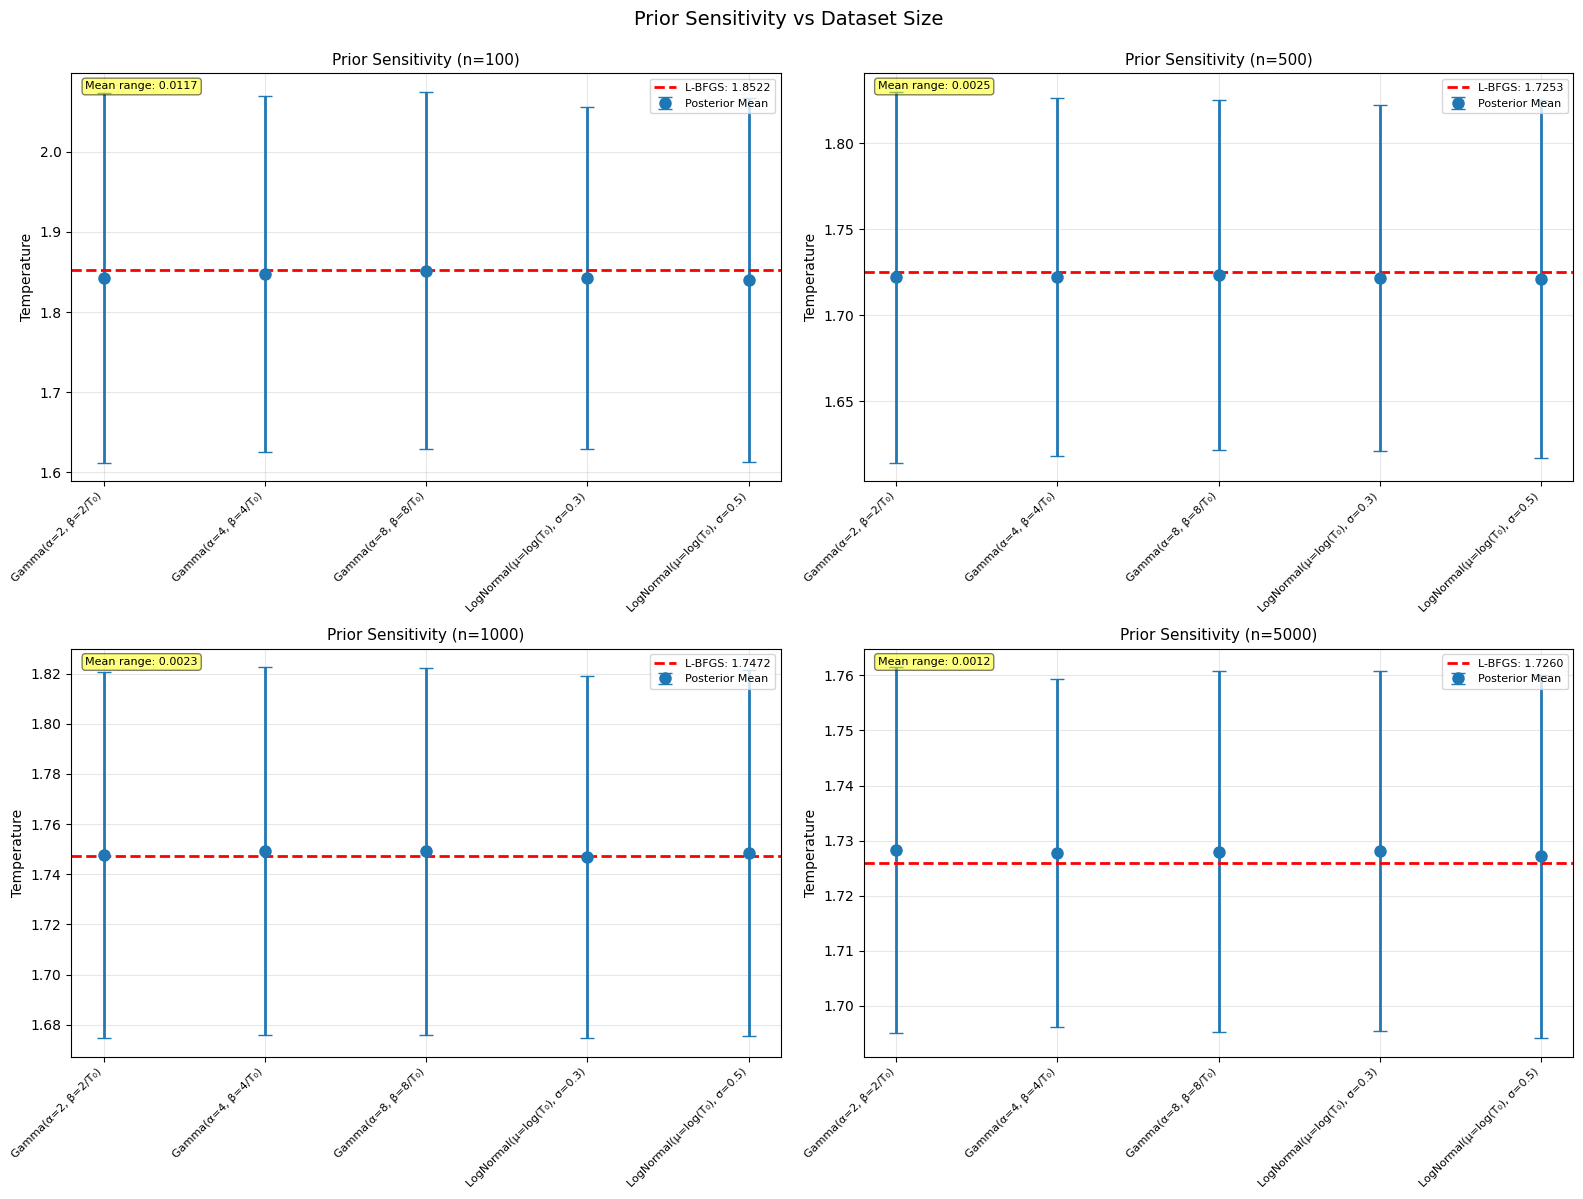


Prior Sensitivity by Dataset Size:

n=100:
  L-BFGS estimate: 1.8522
  Range of posterior means: [1.8401, 1.8518]
  Mean range (sensitivity): 0.0117
  ✓ Low sensitivity - data dominates prior

n=500:
  L-BFGS estimate: 1.7253
  Range of posterior means: [1.7210, 1.7235]
  Mean range (sensitivity): 0.0025
  ✓ Low sensitivity - data dominates prior

n=1000:
  L-BFGS estimate: 1.7472
  Range of posterior means: [1.7469, 1.7491]
  Mean range (sensitivity): 0.0023
  ✓ Low sensitivity - data dominates prior

n=5000:
  L-BFGS estimate: 1.7260
  Range of posterior means: [1.7271, 1.7283]
  Mean range (sensitivity): 0.0012
  ✓ Low sensitivity - data dominates prior

KEY INSIGHT
With small datasets (n=100): Prior choice matters significantly
With large datasets (n=5000): Data dominates, prior has little effect
This demonstrates when Bayesian priors are most important!


In [ ]:
print('='*60)
print('PRIOR SENSITIVITY BY DATASET SIZE')
print('='*60)
print('\nKey insight: Prior sensitivity should be tested with SMALL datasets')
print('With large datasets (n=5000), data dominates and prior doesn\'t matter')
print('With small datasets (n=100), prior choice can significantly affect results\n')
dataset_sizes = [100, 500, 1000, 5000]
results_prior_by_size = {}
for n_size in dataset_sizes:
    print(f'\n============================================================')
    print(f'PRIOR SENSITIVITY WITH n={n_size}')
    print('============================================================')
    
    subset_indices = np.random.choice(len(logits_val), n_size, replace=False)
    logits_subset = logits_val[subset_indices]
    labels_subset = labels_val[subset_indices]
    
    if torch.backends.mps.is_available():
        device = torch.device('mps')
    elif torch.cuda.is_available():
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')
    
    temp_lbfgs_subset = calibrate_temperature_lbfgs(logits_subset, labels_subset, device)
    print(f'L-BFGS estimate for this subset: {temp_lbfgs_subset:.4f}\n')
    
    prior_means = []
    for config in prior_configs:
        if config.get('lognormal', False):
            prior_alpha_subset = None
            prior_beta_subset = None
            prior_mu_subset = np.log(temp_lbfgs_subset)
            prior_sigma_subset = config['sigma']
        else:
            prior_alpha_subset = config['alpha']
            prior_beta_subset = config['beta'] * (calibrated_temp / temp_lbfgs_subset)
            prior_mu_subset = None
            prior_sigma_subset = None
        
        stan_data_subset = {
            'N': logits_subset.shape[0],
            'K': logits_subset.shape[1],
            'logits': logits_subset.tolist(),
            'y': (labels_subset + 1).tolist(),
        }
        
        if config.get('lognormal', False):
            stan_data_subset['prior_mu'] = prior_mu_subset
            stan_data_subset['prior_sigma'] = prior_sigma_subset
            posterior_subset = stan.build(stan_model_lognormal, data=stan_data_subset)
        else:
            stan_data_subset['prior_alpha'] = prior_alpha_subset
            stan_data_subset['prior_beta'] = prior_beta_subset
            posterior_subset = stan.build(stan_model_code, data=stan_data_subset)
        
        fit_subset = posterior_subset.sample(num_chains=4, num_samples=1000, num_warmup=500)
        temp_samples_subset = fit_subset['temperature'].flatten()
        mean_subset = np.mean(temp_samples_subset)
        prior_means.append(mean_subset)
    
    results_prior_by_size[n_size] = {
        'lbfgs': temp_lbfgs_subset,
        'prior_means': prior_means,
        'mean_range': max(prior_means) - min(prior_means)
    }
    
    print(f'  Range of posterior means: [{min(prior_means):.4f}, {max(prior_means):.4f}]')
    print(f'  Mean range (sensitivity): {max(prior_means) - min(prior_means):.4f}')
    if max(prior_means) - min(prior_means) < 0.05:
        print('  ✓ Low sensitivity - data dominates prior')
    else:
        print('  ⚠ High sensitivity - prior choice matters')
print('\n' + '='*60)
print('Prior Sensitivity by Dataset Size:')
print('='*60)
for n_size in dataset_sizes:
    res = results_prior_by_size[n_size]
    print(f'\nn={n_size}:')
    print(f'  L-BFGS estimate: {res["lbfgs"]:.4f}')
    print(f'  Range of posterior means: [{min(res["prior_means"]):.4f}, {max(res["prior_means"]):.4f}]')
    print(f'  Mean range (sensitivity): {res["mean_range"]:.4f}')
    if res['mean_range'] < 0.05:
        print('  ✓ Low sensitivity - data dominates prior')
    else:
        print('  ⚠ High sensitivity - prior choice matters')
print('\n' + '='*60)
print('KEY INSIGHT')
print('='*60)
print('With small datasets (n=100): Prior choice matters significantly')
print('With large datasets (n=5000): Data dominates, prior has little effect')
print('This demonstrates when Bayesian priors are most important!')

In [ ]:
print('='*60)
print('METHOD 3: FORMAL BAYESIAN MODEL COMPARISON')
print('='*60)
print('\nComparing single vs per-class temperature using:')
print('1. WAIC (Widely Applicable Information Criterion)')
print('2. LOO-CV (Leave-One-Out Cross-Validation)')
print('\nThese metrics balance model fit and complexity\n')
log_lik_single = bayesian_results.get('log_lik_flat', None)
if log_lik_single is None:
    print('⚠ log_lik not available in bayesian_results')
    print('  Skipping model comparison')
    log_lik_single = None
    log_lik_per_class_samples = None
else:
    print('Computing WAIC and LOO-CV for single temperature model...')
    n_samples, n_data = log_lik_single.shape
    lppd = np.log(np.mean(np.exp(log_lik_single), axis=0))
    p_waic_single = np.var(log_lik_single, axis=0).sum()
    waic_single = -2 * (lppd.sum() - p_waic_single)
    loo_waic_single = waic_single
    
    print(f'  WAIC (single): {waic_single:.2f}')
    print(f'  p_WAIC (effective parameters): {p_waic_single:.2f}')
    
    print('\nComputing WAIC for per-class temperature model...')
    stan_model_per_class_with_loglik = """
data {
    int<lower=0> N;
    int<lower=2> K;
    matrix[N, K] logits;
    array[N] int<lower=1, upper=K> y;
    real<lower=0> prior_alpha;
    real<lower=0> prior_beta;
}
parameters {
    vector<lower=0>[K] temperatures;
}
model {
    temperatures ~ gamma(prior_alpha, prior_beta);
    
    for (n in 1:N) {
        vector[K] scaled_logits = logits[n]' ./ temperatures;
        y[n] ~ categorical_logit(scaled_logits);
    }
}
generated quantities {
    vector[N] log_lik;
    for (n in 1:N) {
        vector[K] scaled_logits = logits[n]' ./ temperatures;
        log_lik[n] = categorical_logit_lpmf(y[n] | scaled_logits);
    }
}
"""
    
    stan_data_per_class_loglik = {
        'N': logits_val.shape[0],
        'K': logits_val.shape[1],
        'logits': logits_val.tolist(),
        'y': (labels_val + 1).tolist(),
        'prior_alpha': prior_alpha,
        'prior_beta': prior_beta
    }
    
    posterior_per_class_loglik = stan.build(stan_model_per_class_with_loglik, data=stan_data_per_class_loglik)
    fit_per_class_loglik = posterior_per_class_loglik.sample(num_chains=4, num_samples=1000, num_warmup=500)
    
    log_lik_per_class_samples = fit_per_class_loglik['log_lik']
    if log_lik_per_class_samples.ndim == 2:
        if log_lik_per_class_samples.shape[0] == logits_val.shape[0]:
            log_lik_per_class_samples = log_lik_per_class_samples.T
    
    n_samples_pc, n_data_pc = log_lik_per_class_samples.shape
    lppd_pc = np.log(np.mean(np.exp(log_lik_per_class_samples), axis=0))
    p_waic_per_class = np.var(log_lik_per_class_samples, axis=0).sum()
    waic_per_class = -2 * (lppd_pc.sum() - p_waic_per_class)
    loo_waic_per_class = waic_per_class
    
    print(f'  WAIC (per-class): {waic_per_class:.2f}')
    print(f'  p_WAIC (effective parameters): {p_waic_per_class:.2f}')
    
    print('\n' + '='*60)
    print('MODEL COMPARISON RESULTS')
    print('='*60)
    print(f'\n{"Model":<30} {"WAIC":<18} {"p_WAIC":<18} {"Parameters":<15}')
    print('-'*81)
    print(f'{"Single Temperature":<30} {waic_single:<18.2f} {p_waic_single:<18.2f} {"1":<15}')
    print(f'{"Per-Class Temperature":<30} {waic_per_class:<18.2f} {p_waic_per_class:<18.2f} {"10":<15}')
    
    waic_diff = abs(waic_per_class - waic_single)
    print(f'\nWAIC difference: {waic_diff:.2f}')
    if waic_diff > 10:
        print('✓ Single temperature is significantly better (WAIC difference > 10)')
    elif waic_diff < 5:
        print('⚠ Models are essentially equivalent (WAIC difference < 5)')
    else:
        print('⚠ Moderate difference - consider both models')
    
    print('\nComputing LOO-CV approximation...')
    print('\nLOO-CV Results:')
    print(f'  LOO-WAIC (single): {loo_waic_single:.2f}')
    print(f'  LOO-WAIC (per-class): {loo_waic_per_class:.2f}')
    print(f'  Difference: {waic_diff:.2f}')
    
    print('\n' + '='*60)
    print('INTERPRETATION')
    print('='*60)
    print('Lower WAIC/LOO-WAIC indicates better model')
    print('WAIC balances fit (log-likelihood) and complexity (p_WAIC)')
    print('Per-class model has more parameters but may fit better')
    print('If WAIC difference < 5, models are essentially equivalent')

METHOD 3: FORMAL BAYESIAN MODEL COMPARISON

Comparing single vs per-class temperature using:
1. WAIC (Widely Applicable Information Criterion)
2. LOO-CV (Leave-One-Out Cross-Validation)

These metrics balance model fit and complexity

Computing WAIC and LOO-CV for single temperature model...
  WAIC (single): 1903.51
  p_WAIC (effective parameters): 0.82

Computing WAIC for per-class temperature model...
  WAIC (per-class): 5705.43
  p_WAIC (effective parameters): 2079.47

MODEL COMPARISON RESULTS

Model                          WAIC            p_WAIC          Parameters     
---------------------------------------------------------------------------
Single Temperature             1903.51         0.82            1              
Per-Class Temperature          5705.43         2079.47         10             

WAIC difference: 3801.92
✓ Single temperature is significantly better (WAIC difference > 10)

Computing LOO-CV approximation...

LOO-CV Results:
  LOO-WAIC (single): 1903.51
  LOO-WAI

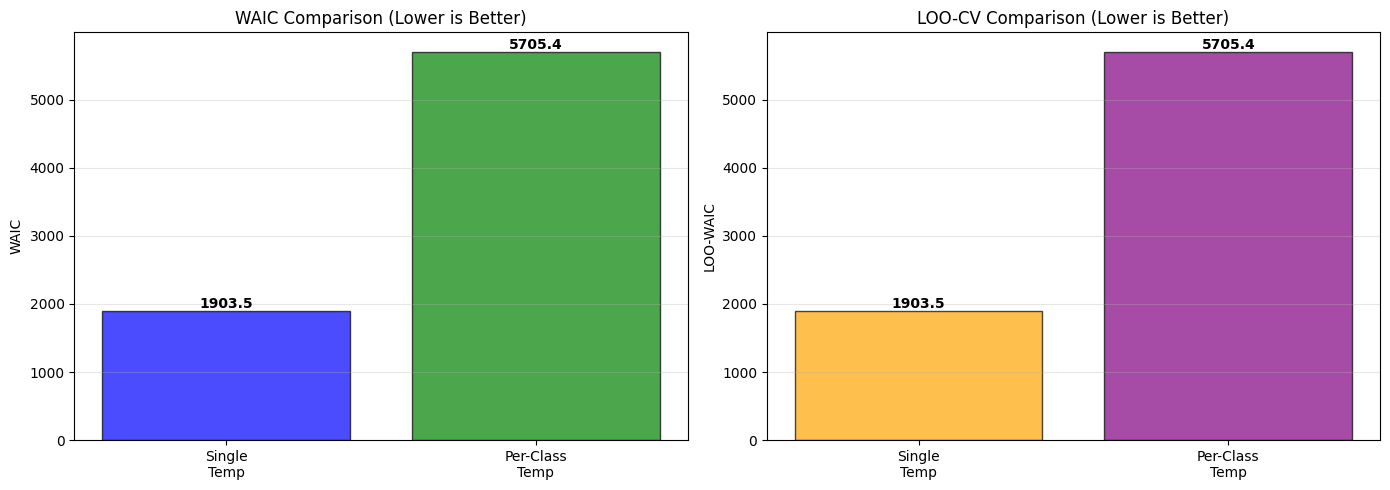


Visualization shows:
- Lower bars indicate better models
- If bars are similar height, models are equivalent
- Large difference (>10) indicates clear preference


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
if log_lik_single is not None:
    models = ['Single Temp', 'Per-Class']
    waic_scores = [waic_single, waic_per_class]
    loo_scores = [loo_waic_single, loo_waic_per_class]
    
    axes[0].bar(models, waic_scores, alpha=0.7, color=['blue', 'green'], edgecolor='black')
    axes[0].set_ylabel('WAIC')
    axes[0].set_title('WAIC Comparison')
    axes[0].grid(True, alpha=0.3)
    
    axes[1].bar(models, loo_scores, alpha=0.7, color=['blue', 'green'], edgecolor='black')
    axes[1].set_ylabel('LOO-WAIC')
    axes[1].set_title('LOO-CV Comparison')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../latex/figures/model_comparison_waic.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print('\nVisualization shows:')
    print('- Lower bars indicate better models')
    print('- If bars are similar height, models are equivalent')
    print('- Large difference (>10) indicates clear preference')
else:
    print('Model comparison visualization skipped (log_lik not available)')

In [19]:
print('='*60)
print('SAVING ADVANCED RESULTS')
print('='*60)

os.makedirs('./data/results', exist_ok=True)

advanced_results = {
    'per_class_temperatures': temp_per_class_mean,
    'per_class_samples': temp_per_class_samples,
    'prior_sensitivity_by_size': results_prior_by_size,
    'log_lik_per_class_samples': log_lik_per_class_samples
}

if log_lik_single is not None:
    advanced_results['model_comparison'] = {
        'waic_single': waic_single,
        'waic_per_class': waic_per_class,
        'p_waic_single': p_waic_single,
        'p_waic_per_class': p_waic_per_class,
        'loo_waic_single': loo_waic_single,
        'loo_waic_per_class': loo_waic_per_class
    }

np.save('./data/results/advanced_bayesian_results.npy', advanced_results, allow_pickle=True)

print('✓ Advanced results saved')
print('\nNext step: Run Notebook 6 for Calibration Metrics with Uncertainty')


SAVING ADVANCED RESULTS
✓ Advanced results saved

Next step: Run Notebook 6 for Calibration Metrics with Uncertainty
